# Structural properties of Hypergraphs
- Hypergraph centrality measures
- Extracting communities on hypergraphs

<code>Hypergraphx</code> is a Python package designed to model and analyze hypergraph structures, presented in the following article:

> Quintino Francesco Lotito, Martina Contisciani, Caterina De Bacco, Leonardo Di Gaetano, Luca Gallo, Alberto Montresor, Federico Musciotto, Nicolò Ruggeri, Federico Battiston, *Hypergraphx: a library for higher-order network analysis*, Journal of Complex Networks, Volume 11, Issue 3, June 2023, cnad019, https://doi.org/10.1093/comnet/cnad019


This Notebook is meant to be an introductory tutorial. For more advanced features, please refer to the official [documentation](hypergraphx.readthedocs.io/en/latest/#).

In this tutorial, we will use hgx v1.7.3.

The easiest way to install hypergraphx is via pip:


In [5]:
pip install hypergraphx==1.7.3

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


Start by importing the library:

In [6]:
import hypergraphx as hgx

## Hypergraph Analysis
In this section, we will go through basic commands to retrieve information from a hypergraph. First, let's download the data and load a sample hypergraph.

In [7]:
# !wget -qO - https://raw.githubusercontent.com/andreafailla/andreafailla.github.io/main/static/uploads/data/icwsm2025.tar.gz | tar -xzv
!curl -L https://raw.githubusercontent.com/andreafailla/andreafailla.github.io/main/static/uploads/data/icwsm2025.tar.gz | tar -xzv


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  3  102k    3  4125    0     0  10375      0  0:00:10 --:--:--  0:00:10 10364x icwsm2025/
x icwsm2025/.DS_Store
x icwsm2025/minorities-labels.csv
x icwsm2025/politics-edges.txt
100  102k  100  102k    0     0   228k      0 --:--:-- --:--:-- --:--:--  228k

x icwsm2025/guncontrol-edges.txt
x icwsm2025/minorities-edges.txt
x icwsm2025/sample.json
x icwsm2025/guncontrol-labels.csv


In [8]:
from hypergraphx.readwrite.load import load_hypergraph
h = load_hypergraph('icwsm2025/sample.json', file_type='json')

In [9]:
print(h)

Hypergraph with 1000 nodes and 1900 edges.
Distribution of hyperedge sizes: {2: 1000, 3: 500, 4: 300, 5: 100}


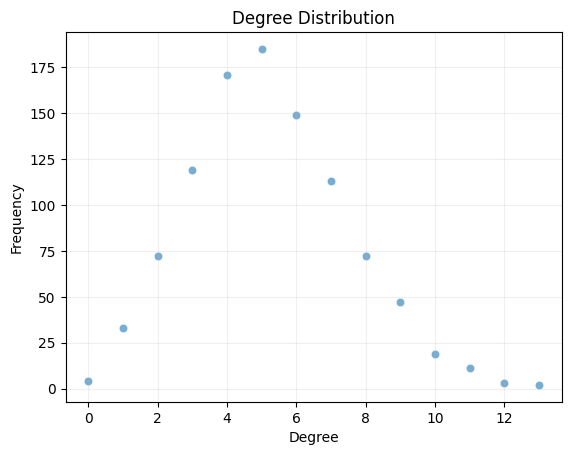

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_degree_distribution(h, loglog=False):
    cnt = h.degree_distribution()
    deg = cnt.keys()
    freq = cnt.values()
    ax = sns.scatterplot(x=deg, y=freq, alpha=.6)
    ax.set_xlabel('Degree')
    ax.set_ylabel('Frequency')
    ax.set_title('Degree Distribution')
    ax.grid(alpha=.2)
    if loglog:
        ax.loglog()
    plt.show()
plot_degree_distribution(h)

#### Centralities
Pairwise graph measures can be extended to hypergraphs via the **s-analytics framework** [1].

The underlying idea is that two hyperedges can intersect at any number of vertices, and two vertices can belong to any number of shared hyperedges.

This concept implies that walks on a hypergraph have a *length* and a *width* `s`.  The parameter `s` controls for either:
- the size of edge intersection, or
- the number of shared hyperedges between each pair of consecutive vertices.

[1] S.G. Aksoy, C. Joslyn, C. Ortiz Marrero, et al. *Hypernetwork science via high-order hypergraph walks*. EPJ Data Sci. 9, 16 (2020).

To capture information about the size of hyperedge intersections, we can build the **line-graph projection** of a hypergraph.

**Highlight**: The **line-graph projection** of an hypergraph H is a graph whose nodes correspond to the hyperedges of H, and edges corresponding to nonempty hyperedge intersections.

> Image from A. Antelmi, G. Cordasco, M. Polato, V. Scarano, C. Spagnuolo, and D. Yang. 2023. *A Survey on Hypergraph Representation Learning*. ACM Comput. Surv. 56, 1, Article 24.

![image.png](https://i.ibb.co/kVNXqjXJ/graphs.png)

We can then compute the centrality values of the nodes in the line graph to get a measure of the importance of the hyperedges in the origin hypergraph.

In [11]:
from hypergraphx.representations.projections import line_graph
lg, id_to_edge = line_graph(h)

Then, we can compute hyperedge importance scores in the line graph with the library `networkx`:

In [12]:
import networkx as nx
cls = nx.closeness_centrality(lg)
cls = {id_to_edge[k]: v for k, v in cls.items()} # remap edges

To get the score for a hyperedge:

In [13]:
from hypergraphx.measures.s_centralities import s_closeness

my_edge = h.get_edges()[0]
print('my edge:', my_edge)

cls_1 = s_closeness(h, s=1)
print(f"Closeness centrality for {my_edge}: {cls_1[my_edge]}")



my edge: (163, 283)
Closeness centrality for (163, 283): 0.2932818532818533


`Hypergraphx` provides a method to directly compute various centrality measures. You can also modify the parameter `s` to compute scores on larger overlaps:

In [14]:
from hypergraphx.measures.s_centralities import s_closeness
cls_2 = s_closeness(h, s=2)
print(f"Closeness 2-centrality for {my_edge}: {cls_2[my_edge]}")

Closeness 2-centrality for (163, 283): 0.0


We can get a measure of node importance by applying the same approach on the dual representation of the hypergraph.

**Highlight**: The **dual** H* of a hypergraph H is the hypergraph constructed by swapping the roles of nodes and hyperedges.

This is implemented in the most recent versions of `hgx`, but not in the one we are using. Here is a function that compute node centralities on hypergraphs:


In [15]:
def dual_hypergraph(h: hgx.Hypergraph) -> hgx.Hypergraph:
    """
    Returns the dual hypergraph of the input hypergraph,
    and a dictionary mapping dual edges to original nodes.
    """
    # label the original edges so we can use them as “nodes” in the dual
    e2label = {e: f'e{idx}' for idx, e in enumerate(h.get_edges())}

    # build the dual edge list: for every original node,
    # collect all original edges that contain it
    dualedges_to_node = dict()
    for v in h.get_nodes():
        incident = tuple(sorted([e2label[e] for e in h.get_incident_edges(node=v)]))
        # ignore isolated vertices (would give empty hyper-edges)
        if incident:
            dualedges_to_node[incident] = v

    dual = hgx.Hypergraph(edge_list=list(dualedges_to_node.keys()))
    return dual, dualedges_to_node


def s_closeness_nodes(h: hgx.Hypergraph, s=1) -> dict:
  """
  Computes closeness centrality for each node in the hypergraph.
  Returns a dictionary where keys are nodes and values are centrality scores.
  """
  dual, eids_to_node = dual_hypergraph(h)
  closeness = s_closeness(dual, s=s)
  return {eids_to_node[k]: v for k, v in closeness.items()}

In [16]:
n_cls_1 = s_closeness_nodes(h)
n_cls_1[1]

0.2869088811995386

Finally, other node centrality scores are available, such as the subhypergraph centrality defined in
> *Estrada, E., & Rodriguez-Velazquez, J. A. (2005). Complex networks as hypergraphs. arXiv preprint physics/0505137.*

In [17]:
from hypergraphx.measures.sub_hypergraph_centrality import subhypergraph_centrality

shc = subhypergraph_centrality(h)
# map nodes to array values
shc = dict(zip(h.get_nodes(), shc))

In [18]:
shc[1]

np.float64(10.078958349224381)

## Communities on Hypergraphs

Besides focusing on node-level or system-level properties, sometimes researchers may be interested in analyzing the network at an "intermediate" granularity.
We already (partially) explored the meso-scale organization of hypergraphs, when we focused on hyperedge sizes and centralities.

If we are interested in even more coarse groupings, we can resort to community detection approaches, which exploit the structural properties of the hypernetwork to find larger groups of nodes/edges.

### Hyperlink Communities
`Hypergraphx` implements some algorithms to identify communities on hypergraphs. Here, we will focus on the simplest one, the **Hyperlink Communities algorithm**, which is described in:
> *Lotito, Q. F., Musciotto, F., Montresor, A., & Battiston, F. (2024). Hyperlink communities in higher-order networks. Journal of Complex Networks, 12(2), cnae013.*

This algorithm works in two steps:
1. It constructs a dendrogram by aggregating hyperedges based on overlap size.
2. It returns the partition at a given cut height (a parameter of the algorithm).

Does this sound familiar? It's essentially the same approach as that of Hierachical Clustering in data mining tasks!

As a first step, we import necessary functions and compute the dendrogram. Some information is printed by default. Note how the algorithm is only applied to the largest connected component.

In [19]:
from hypergraphx.communities.hyperlink_comm.hyperlink_communities import \
  hyperlink_communities, get_num_hyperlink_communties, overlapping_communities

dendrogram = hyperlink_communities(h)

Hypergraph info - nodes: 1000 edges: 1900
Subhypergraph info - nodes: 996 edges: 1900
Computing distances
Done 0 of 996
Done 1 of 996
Done 2 of 996
Done 3 of 996
Done 4 of 996
Done 5 of 996
Done 6 of 996
Done 7 of 996
Done 8 of 996
Done 9 of 996
Done 10 of 996
Done 11 of 996
Done 12 of 996
Done 13 of 996
Done 14 of 996
Done 15 of 996
Done 16 of 996
Done 17 of 996
Done 18 of 996
Done 19 of 996
Done 20 of 996
Done 21 of 996
Done 22 of 996
Done 23 of 996
Done 24 of 996
Done 25 of 996
Done 26 of 996
Done 27 of 996
Done 28 of 996
Done 29 of 996
Done 30 of 996
Done 31 of 996
Done 32 of 996
Done 33 of 996
Done 34 of 996
Done 35 of 996
Done 36 of 996
Done 37 of 996
Done 38 of 996
Done 39 of 996
Done 40 of 996
Done 41 of 996
Done 42 of 996
Done 43 of 996
Done 44 of 996
Done 45 of 996
Done 46 of 996
Done 47 of 996
Done 48 of 996
Done 49 of 996
Done 50 of 996
Done 51 of 996
Done 52 of 996
Done 53 of 996
Done 54 of 996
Done 55 of 996
Done 56 of 996
Done 57 of 996
Done 58 of 996
Done 59 of 996
Done

To understand where to perform the cut, we can try different heights and compute the number of resulting communities at that height.

In [20]:
nums = []
cuts = [0.25, 0.5, 0.75,
        0.80, 0.85, 0.90,
        0.95, 0.99, 0.999]
for cut_height in cuts:
  nums.append(get_num_hyperlink_communties(dendrogram, cut_height))

In [21]:
dict(zip(cuts, nums))

{0.25: 1900,
 0.5: 1892,
 0.75: 1006,
 0.8: 825,
 0.85: 510,
 0.9: 462,
 0.95: 308,
 0.99: 117,
 0.999: 11}

Then, we compute the actual communities with the following:

In [22]:
communities = overlapping_communities(h, dendrogram, cut_height=0.999)

This function outputs a dictionary where:
- Keys are the nodes, and
- Values are the list of communities the node is part of.

Note that this is an overlapping community detection method. This means that nodes can be part of multiple communities at the same time. The following function visualizes the distribution of community memberships across nodes.

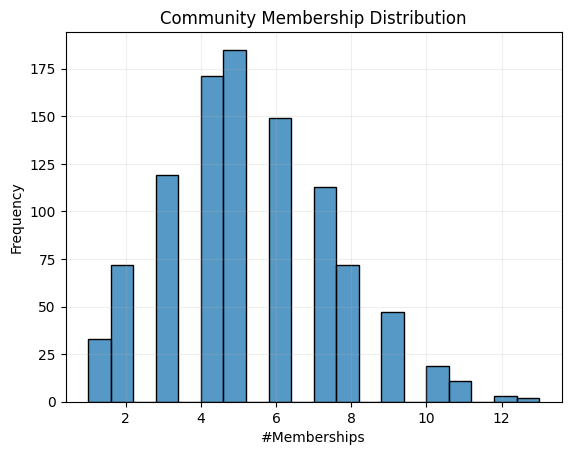

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
def membership_distribution(communities):
  ms = [len(c) for c in communities.values()]
  ax = sns.histplot(ms)
  ax.set_xlabel('#Memberships')
  ax.set_ylabel('Frequency')
  ax.set_title('Community Membership Distribution')
  ax.grid(alpha=.2)


membership_distribution(communities)

What about community sizes?

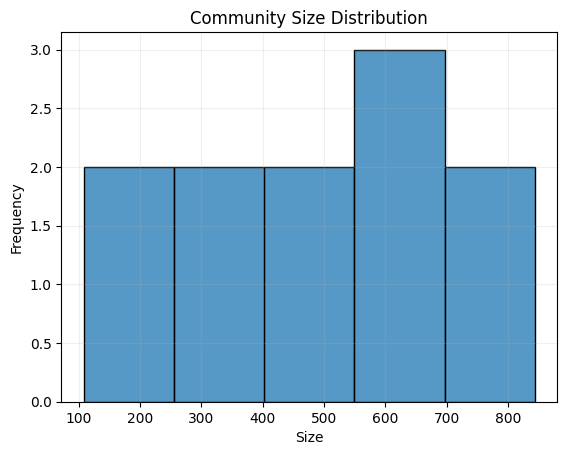

In [24]:
def community_size_distribution(communities):
  com_to_nodes = {}
  for node, coms in communities.items():
    for com in coms:
      if com not in com_to_nodes:
        com_to_nodes[com] = []
      com_to_nodes[com].append(node)
  sizes = [len(com_to_nodes[com]) for com in com_to_nodes]
  ax = sns.histplot(sizes)
  ax.set_xlabel('Size')
  ax.set_ylabel('Frequency')
  ax.set_title('Community Size Distribution')
  ax.grid(alpha=.2)


community_size_distribution(communities)

## Reddit

Reddit (launched in 2005) is a social news aggregation, web content rating and discussion website, ranked as #9 most visited website in the world (as of Aprile 2025) with over 100 million daily active users (as of 2024).

Reddit has become a golden pot for researchers thanks to the
openness (not anymore), richness, and quality of its data [2].
You can find collections of all reddit data online as a direct download or through torrent (https://academictorrents.com/details/ba051999301b109eab37d16f027b3f49ade2de13) thanks to the work of some researchers that have collected the data also after the controversial changes of Reddit API in April 2023.

[2] A.N. Medvedev, R. Lambiotte, and J.-C. Delvenne. 2019. *The Anatomy of Reddit: An Overview of Academic Research. Springer Proceedings in Complexity, 183–204.*

## Exercises: Political Debates on Reddit

The reddit political debates dataset contains higher-order interactions emerging from political discussions during the first 2 years and a half of Donald Trump's presidency.

Take a look at the file in *icwsm2025/politics-edges.txt*. The data is provided as a timestamped edgelist. Each row starts with a timestamp, followed by a space-separated list of nodes.

Each timestamp in [0,4] represents a semester.

The dataset was first released in \[3\] as a pairwise network, and its higher-order structure was analyzed in \[4\].

> [3] *Morini, V., Pollacci, L., & Rossetti, G. (2021). Toward a standard approach for echo chamber detection: Reddit case study. Applied Sciences, 11(12), 5390.*

> [4] *Failla, A., Citraro, S., & Rossetti, G. (2023). Attributed Stream Hypergraphs: temporal modeling of node-attributed high-order interactions. Applied Network Science, 8(1), 31.*

In [25]:
def load_reddit_data(dataset_name, attributes=False, by_timestamp=False):
  if not by_timestamp:
    # res is an hypergraph
    res = hgx.Hypergraph()
    with open(f"icwsm2025/{dataset_name}-edges.txt") as f:
      for line in f:
        edge = [int(x) for x in line.strip().split()[1:]]
        res.add_edge(edge)
    if attributes:
      with open(f"icwsm2025/{dataset_name}-labels.csv") as f:
        labels = {}
        for line in f:
          n, t, l = line.strip().split(',')
          labels[int(n)] = l
        for n, l in labels.items():
          if res.check_node(n):
            res.set_node_metadata(n, {'leaning': l})
  else:
      # res is a list of hypergraphs
      res = [hgx.Hypergraph(), hgx.Hypergraph(),
           hgx.Hypergraph(), hgx.Hypergraph(),
           hgx.Hypergraph()]
      with open(f"icwsm2025/{dataset_name}-edges.txt") as f:
        for line in f:
          line = line.strip().split()
          t = int(line[0])
          edge = [int(x) for x in line[1:]]
          res[t].add_edge(edge)
      if attributes:
        with open(f"icwsm2025/{dataset_name}-labels.csv") as f:
          for line in f:
            n, t, l = line.strip().split(',')
            if res[int(t)].check_node(int(n)):
              res[int(t)].set_node_metadata(int(n), {'leaning': l})
  return res

In [26]:
# USAGE EXAMPLE

dataset = 'politics' # or 'minorities' or 'guncontrol'
attributes = False # whether to load users' estimated political leanings
by_timestamp = False # whether to load one aggregated hypergraph, or
                     # a list of hypergraphs (one for each timestampd)

with open(f"icwsm2025/politics-edges.txt") as f:
      r = f.readlines()
      for i in range(3):
        print(r[i])

with open(f"icwsm2025/politics-labels.csv") as f:
      r = f.readlines()
      for i in range(3):
        print(r[i])

h = load_reddit_data(dataset, attributes, by_timestamp)

print(h)

0	11647 12523 12808 13028

0	11647 11994 12808 13028

0	10940 11155 11647 11994 12808

11647,0,antitrump

12808,0,antitrump

12523,0,neutral

Hypergraph with 3269 nodes and 7079 edges.
Distribution of hyperedge sizes: {4: 569, 5: 163, 3: 1867, 2: 4343, 6: 88, 8: 16, 7: 31, 9: 2}


**E1: Identify the hyperedge with the highest closeness centrality. Then, identify the node with the highest closeness centrality**

In [27]:
from hypergraphx.measures.s_centralities import s_closeness
from collections import Counter

# Compute s=1 closeness centrality for hyperedges
edge_centrality = s_closeness(h, s=1)
max_edge = max(edge_centrality, key=edge_centrality.get)
print("Hyperedge with highest s=1 closeness centrality:", max_edge)
print("Centrality:", edge_centrality[max_edge])

Hyperedge with highest s=1 closeness centrality: (10649, 11017, 12112, 12144)
Centrality: 0.4131739154485693


In [28]:
# Compute closeness centrality for nodes using projection
n_cls = s_closeness_nodes(h)
max_node = max(n_cls, key=n_cls.get)
print("Node with highest closeness centrality:", max_node)
print("Centrality:", n_cls[max_node])

Node with highest closeness centrality: 12144
Centrality: 0.35460928485149845


**E2: Identify one of the largest hyperedges. Compute s-closeness centrality for various s values. Is the largest hyperedge also the highest ranked by centrality? Is this affected by s? Why?**

In [29]:
edges_by_size = sorted(h.get_edges(), key=len, reverse=True)
large_edge = edges_by_size[0]
print("One of the largest hyperedges:", large_edge, "with size:", len(large_edge))

# Compute s-closeness centrality at various s values
for s in [1, 2, 3]:
    sc = s_closeness(h, s=s)
    print(f"s={s}, closeness centrality for large_edge: {sc.get(large_edge, 0)}")
    max_edge = max(sc, key=sc.get)
    print(f"s={s}, max central edge: {max_edge} with score {sc[max_edge]}")

One of the largest hyperedges: (1384, 8804, 10895, 10940, 11155, 12344, 12517, 12551, 12991) with size: 9
s=1, closeness centrality for large_edge: 0.35967698576152324
s=1, max central edge: (10649, 11017, 12112, 12144) with score 0.4131739154485693
s=2, closeness centrality for large_edge: 0.06524058541511951
s=2, max central edge: (10940, 11017, 11422, 11541) with score 0.07681459924428016
s=3, closeness centrality for large_edge: 0.021170113894661485
s=3, max central edge: (10940, 11017, 11422, 11541) with score 0.02493163084924904


**E3: Construct the dendrogram with the hyperlink communities. Then, try 3 thresholds to partition the hypergraph.**

In [30]:
from hypergraphx.communities.hyperlink_comm.hyperlink_communities import (
    hyperlink_communities, get_num_hyperlink_communties, overlapping_communities
)

# Build dendrogram
dendrogram = hyperlink_communities(h)

# Try 3 thresholds
cut_heights = [0.8, 0.9, 0.99]
for cut in cut_heights:
    n_comms = get_num_hyperlink_communties(dendrogram, cut)
    print(f"Cut height {cut} → {n_comms} communities")

Hypergraph info - nodes: 3269 edges: 7079
Subhypergraph info - nodes: 3219 edges: 7054
Computing distances
dist computed
Cut height 0.8 → 825 communities
Cut height 0.9 → 462 communities
Cut height 0.99 → 117 communities


**E4: Cut the dendrogram at 0.99. Find the node with the highest number of community memberships and compute its degree.**

In [31]:
# Compute communities at cut height 0.99
communities = overlapping_communities(h, dendrogram, cut_height=0.99)

# Find node with most memberships
node_memberships = {node: len(c) for node, c in communities.items()}
max_node = max(node_memberships, key=node_memberships.get)

print(f"Node with most community memberships: {max_node} ({node_memberships[max_node]} memberships)")

# Compute degree of that node
incident_edges = h.get_incident_edges(max_node)
print(f"Degree (number of incident edges): {len(incident_edges)}")

Node with most community memberships: 10895 (143 memberships)
Degree (number of incident edges): 219
